In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import joblib
from joblib import dump, load

In [2]:
df = pd.read_csv('/SSD/p76111262/CIC2018_csv/preprocess_attack.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dst Port           2644 non-null   int64  
 1   Timestamp          2644 non-null   object 
 2   Flow Duration      2644 non-null   float64
 3   Tot Fwd Pkts       2644 non-null   float64
 4   Tot Bwd Pkts       2644 non-null   float64
 5   TotLen Fwd Pkts    2644 non-null   float64
 6   TotLen Bwd Pkts    2644 non-null   float64
 7   Fwd Pkt Len Max    2644 non-null   float64
 8   Fwd Pkt Len Min    2644 non-null   float64
 9   Fwd Pkt Len Mean   2644 non-null   float64
 10  Fwd Pkt Len Std    2644 non-null   float64
 11  Bwd Pkt Len Max    2644 non-null   float64
 12  Bwd Pkt Len Min    2644 non-null   float64
 13  Bwd Pkt Len Mean   2644 non-null   float64
 14  Bwd Pkt Len Std    2644 non-null   float64
 15  Flow Byts/s        2644 non-null   float64
 16  Flow Pkts/s        2641 

In [3]:
def determine_sub_label(label):
    if label in ['DDoS_LOIC-HTTP', 'DDoS_HOIC', 'DDoS_LOIC-UDP']:
        return "DDoS"
    elif label in ['DoS_SlowHTTPTest', 'DoS_Slowloris', 'DoS_Hulk', 'DoS_GoldenEye']:
        return "DoS"
    elif label in ['BruteForce-XSS', 'BruteForce-Web', 'SQL-Injection']:
        return "Web"
    elif label in ['BruteForce-SSH', 'BruteForce-FTP']:
        return "Auth"
    else:
        return "Other"
    
df['Sub_Label'] = df['Label'].apply(determine_sub_label)


In [4]:
unique_labels = df['Sub_Label'].unique()
print(unique_labels)

['Auth' 'DoS' 'DDoS' 'Web' 'Other']


In [5]:
# 保存修改後的DataFrame到新的CSV文件
df.to_csv('/SSD/p76111262/CIC2018_csv/CIC2018_attack_with_subset.csv', index=False)

In [6]:
df = df.fillna(0)
df.isnull().sum().to_dict()

{'Dst Port': 0,
 'Timestamp': 0,
 'Flow Duration': 0,
 'Tot Fwd Pkts': 0,
 'Tot Bwd Pkts': 0,
 'TotLen Fwd Pkts': 0,
 'TotLen Bwd Pkts': 0,
 'Fwd Pkt Len Max': 0,
 'Fwd Pkt Len Min': 0,
 'Fwd Pkt Len Mean': 0,
 'Fwd Pkt Len Std': 0,
 'Bwd Pkt Len Max': 0,
 'Bwd Pkt Len Min': 0,
 'Bwd Pkt Len Mean': 0,
 'Bwd Pkt Len Std': 0,
 'Flow Byts/s': 0,
 'Flow Pkts/s': 0,
 'Flow IAT Mean': 0,
 'Flow IAT Std': 0,
 'Flow IAT Max': 0,
 'Flow IAT Min': 0,
 'Fwd IAT Tot': 0,
 'Fwd IAT Mean': 0,
 'Fwd IAT Std': 0,
 'Fwd IAT Max': 0,
 'Fwd IAT Min': 0,
 'Bwd IAT Tot': 0,
 'Bwd IAT Mean': 0,
 'Bwd IAT Std': 0,
 'Bwd IAT Max': 0,
 'Bwd IAT Min': 0,
 'Fwd PSH Flags': 0,
 'Bwd PSH Flags': 0,
 'Fwd URG Flags': 0,
 'Bwd URG Flags': 0,
 'Fwd Header Len': 0,
 'Bwd Header Len': 0,
 'Fwd Pkts/s': 0,
 'Bwd Pkts/s': 0,
 'Pkt Len Min': 0,
 'Pkt Len Max': 0,
 'Pkt Len Mean': 0,
 'Pkt Len Std': 0,
 'Pkt Len Var': 0,
 'FIN Flag Cnt': 0,
 'SYN Flag Cnt': 0,
 'RST Flag Cnt': 0,
 'PSH Flag Cnt': 0,
 'ACK Flag Cnt': 0,
 'U

In [7]:
# 取得float64類型可表示的最大值和最小值
max_float = np.finfo(np.float64).max
min_float = np.finfo(np.float64).min

# 僅選擇數值類型的欄位進行操作
numeric_cols = df.select_dtypes(include=[np.number])

# 遍歷所有數值列，分別取代正無窮大和負無窮大值
for col in numeric_cols:
     df[col] = df[col].replace([np.inf], max_float)
     df[col] = df[col].replace([-np.inf], min_float)

# 檢查替換是否成功
if not df.select_dtypes(include=[np.number]).applymap(np.isfinite).all().all():
     print("仍存在無窮大值或NaN。")
else:
     print("所有無窮大值已成功替換。")
    
# 篩選出所有數值類型的列
numeric_cols = df.select_dtypes(include=[np.number])

# 檢查數值類型的欄位是否包含無限大值
columns_with_inf = numeric_cols.columns.to_series()[np.isinf(numeric_cols).any()]

# 找出包含無窮大值的行索引
rows_with_inf = numeric_cols.index[np.isinf(numeric_cols).any(axis=1)]

# 列印結果
print("包含無窮大值的欄位:", columns_with_inf)
print("包含無窮大值的行索引:", rows_with_inf.tolist())

所有無窮大值已成功替換。
包含無窮大值的欄位: Series([], dtype: object)
包含無窮大值的行索引: []


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def show_graph(df, subset_type):
    # 挑出 'Sub_Label' 列為 subset_type 的資料
    df = df[df['Sub_Label'] == subset_type]

    # 刪除 'Timestamp' 欄位
    columns_to_delete = ['Timestamp', 'Sub_Label']
    df.drop(columns_to_delete, axis=1, inplace=True)

    # 選擇您想要可視化的特徵列（假設Label列為最後一列）
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]  # 假設Label列為最後一列

    # 載入 MinMaxScaler
    scaler = joblib.load('/SSD/p76111262/CIC2018_csv/min_max_scaler.joblib')
    features_scaled = scaler.fit_transform(features)

    # 使用 t-SNE 降維至二維
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    tsne_result = tsne.fit_transform(features_scaled)

    # 獲取唯一的標籤值
    unique_labels = labels.unique()

    # 使用不同的顏色來表示每個類別
    colors = plt.cm.tab10.colors

    # 繪製 t-SNE 的散點圖，不同標籤使用不同顏色
    plt.figure(figsize=(16, 12))
    for i, label in enumerate(unique_labels):
        indices = labels == label
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], alpha=0.5, label=label, color=colors[i])
        
    plt.title('t-SNE')
    plt.legend()
    plt.show()
    plt.savefig(f'pictures/{subset_type}.png') 

/home/p76111262/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


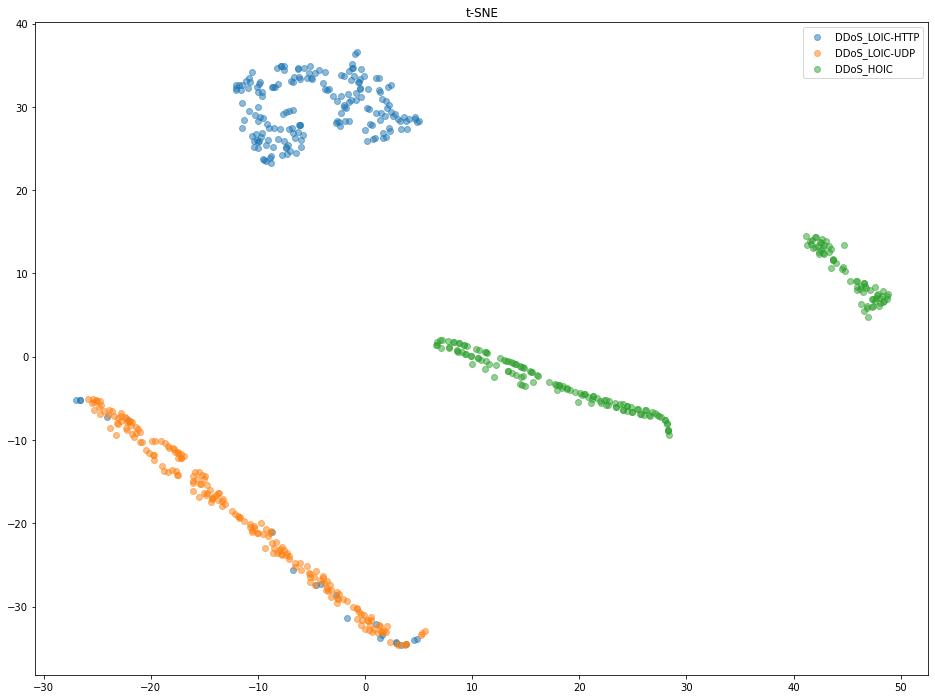

In [9]:
show_graph(df, 'DDoS')

/home/p76111262/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


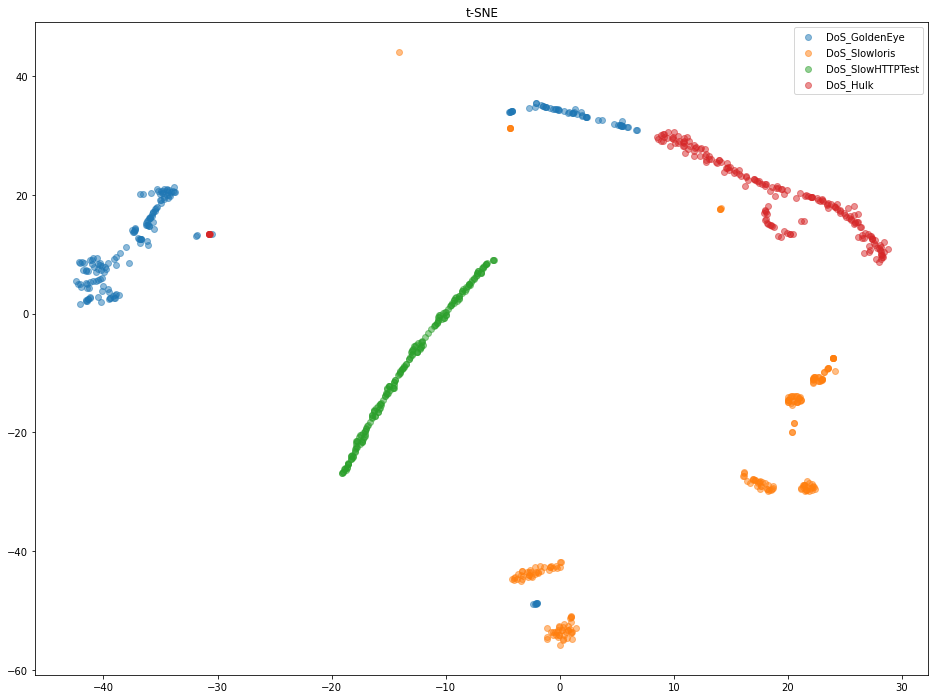

In [10]:
show_graph(df, 'DoS')

/home/p76111262/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


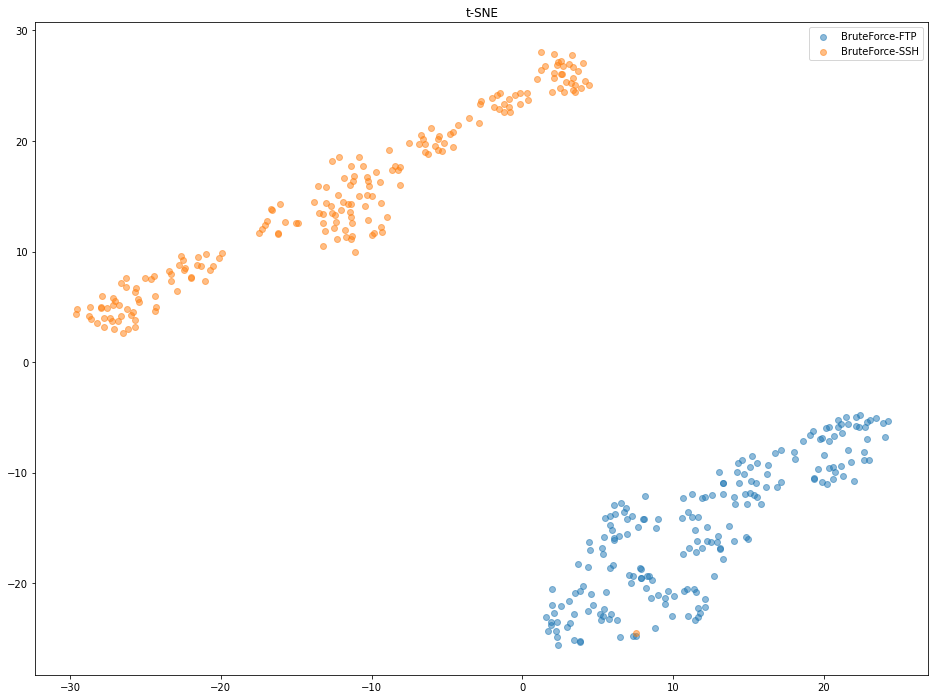

In [11]:
show_graph(df, 'Auth')

/home/p76111262/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


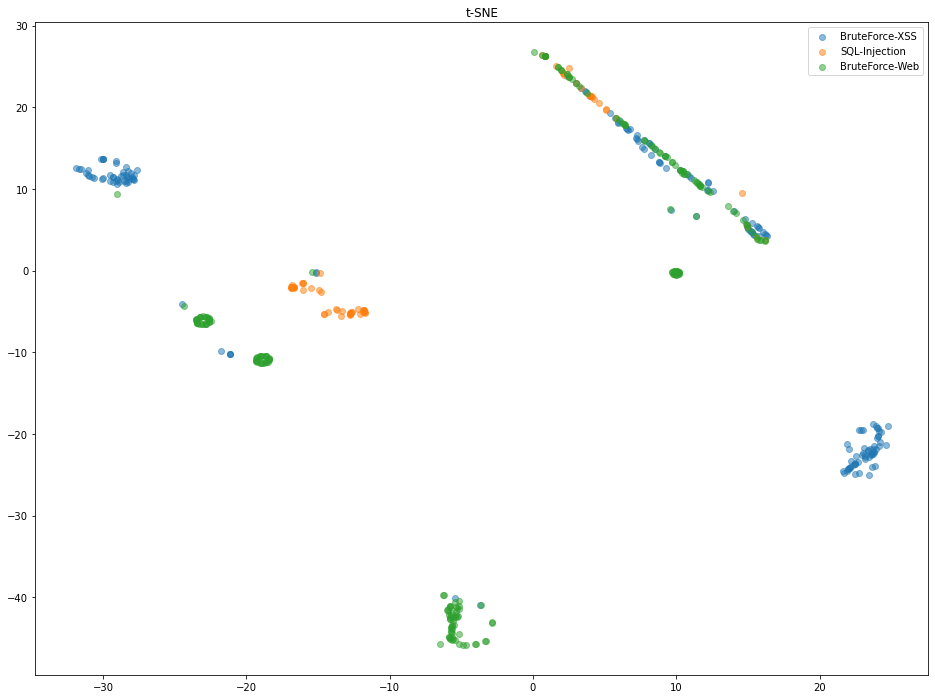

In [12]:
show_graph(df, 'Web')

/home/p76111262/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


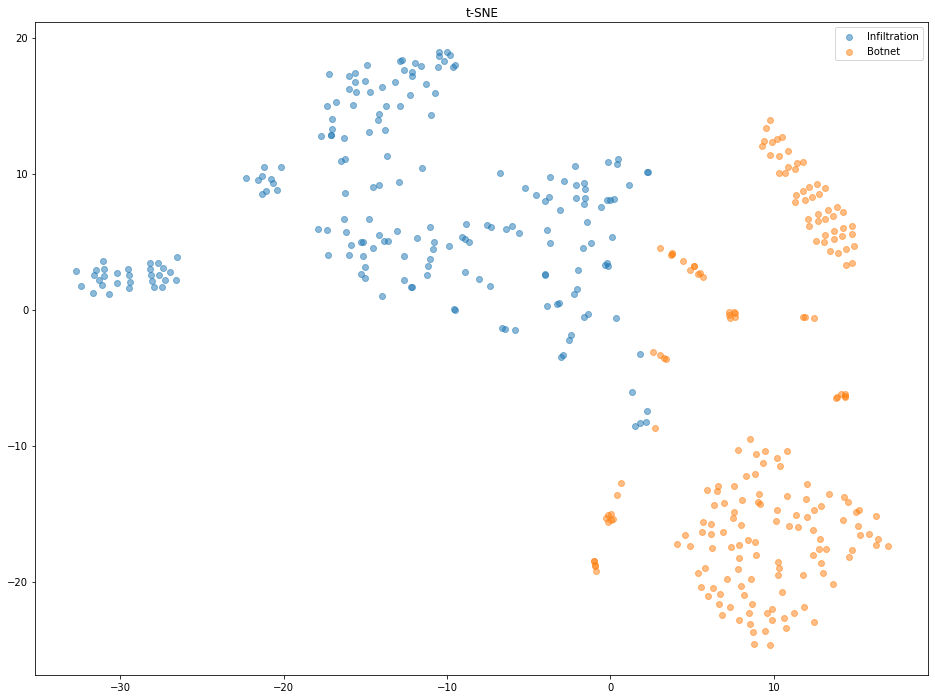

In [13]:
show_graph(df, 'Other')

/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


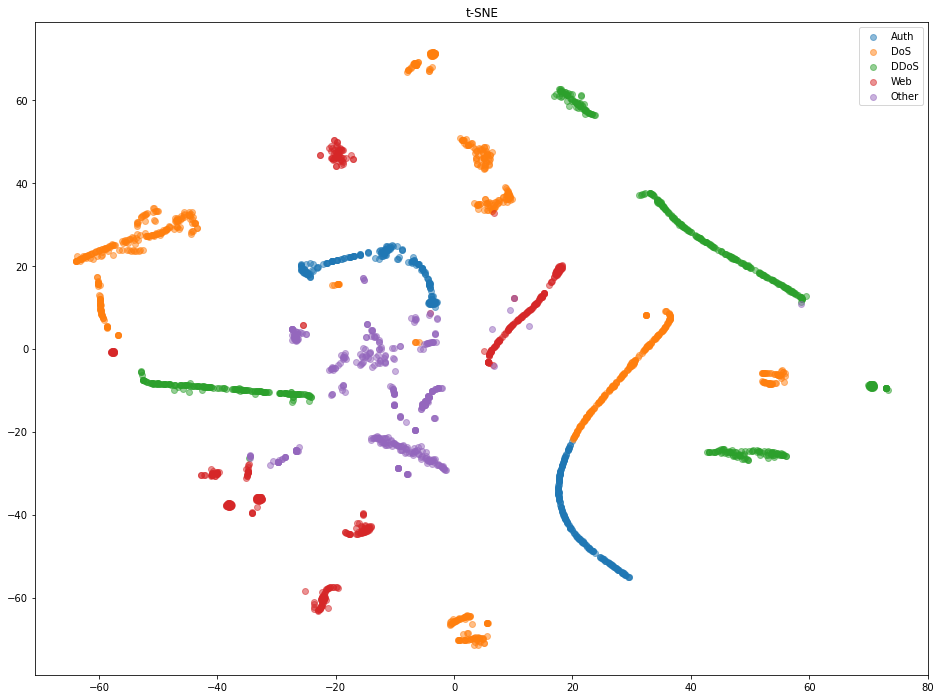

In [14]:
# 刪除 'Timestamp' 欄位
columns_to_delete = ['Timestamp']
df.drop(columns_to_delete, axis=1, inplace=True)

# 選擇您想要可視化的特徵列（假設Label列為最後一列）
features = df.iloc[:, :-2]
labels = df.iloc[:, -1]  # 假設Label列為最後一列

# 對特徵列進行最小-最大標準化
scaler = joblib.load('/SSD/p76111262/CIC2018_csv/min_max_scaler.joblib')
features_scaled = scaler.fit_transform(features)

# 使用 t-SNE 降維至二維
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(features_scaled)

# 獲取唯一的標籤值
unique_labels = labels.unique()

# 使用不同的顏色來表示每個類別
colors = plt.cm.tab10.colors

# 繪製 t-SNE 的散點圖，不同標籤使用不同顏色
plt.figure(figsize=(16, 12))
for i, label in enumerate(unique_labels):
    indices = labels == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], alpha=0.5, label=label, color=colors[i])
plt.title('t-SNE')
plt.legend()
plt.show()


In [15]:
# 假設 data 是你的DataFrame，'target' 是目標變數的列名
X = df.drop(['Label', 'Sub_Label'], axis=1) # 特徵
y = df['Sub_Label'] # 目標變數

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 對特徵進行擬合和轉換
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, '/SSD/p76111262/CIC2018_csv/min_max_scaler_subset.joblib')

label_encoder = LabelEncoder()

# 將目標變數中的字串標籤轉換為數值型標籤
y_encoded = label_encoder.fit_transform(y)

# 劃分資料集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

# 建立XGBoost模型
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# 訓練模型
model.fit(X_train, y_train)

# 儲存模型
joblib.dump(model, '/SSD/p76111262/CIC2018_csv/xgboost_subset.joblib')

# 使用測試集進行預測
y_pred = model.predict(X_test)

# 計算並列印準確率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/p76111262/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Accuracy: 99.39%


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# 初始化模型
logreg = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear')
knn = KNeighborsClassifier(n_neighbors=3)
dt = DecisionTreeClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
mlp = MLPClassifier(random_state=42, max_iter=300)
lgbm = lgb.LGBMClassifier(random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)

# 模型字典
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'Support Vector Machine': svm,
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Gradient Boosting': gb,
    'Multi-layer Perceptron': mlp,
    'LightGBM': lgbm,
    'CatBoost': catboost
}

# 訓練和評估模型
for name, model in models.items():
    model.fit(X_train, y_train)  # 訓練模型
    y_pred = model.predict(X_test)  # 預測測試集
    accuracy = accuracy_score(y_test, y_pred)  # 計算準確率
    print(f"{name} Accuracy: %.2f%%" % (accuracy * 100.0))


Logistic Regression Accuracy: 98.34%


/home/p76111262/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest Accuracy: 99.24%
Support Vector Machine Accuracy: 98.79%
K-Nearest Neighbors Accuracy: 99.70%
Decision Tree Accuracy: 99.24%
Gradient Boosting Accuracy: 99.09%
Multi-layer Perceptron Accuracy: 99.24%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12731
[LightGBM] [Info] Number of data points in the train set: 1983, number of used features: 66
[LightGBM] [Info] Start training from score -1.862266
[LightGBM] [Info] Start training from score -1.492047
[LightGBM] [Info] Start training from score -1.208859
[LightGBM] [Info] Start training from score -1.872054
[LightGBM] [Info] Start training from score -1.787231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L